In [1]:
import os

import numpy as np

import nengo
from nengo.params import Default, NumberParam
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.numpy import rmse

from nengolib.signal import s, nrmse, LinearSystem
from nengolib.synapses import Lowpass

from nengo_bioneurons import make_stimulus, norms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
class ForceNode(nengo.Node):
    def __init__(self, n_neurons, encoders, P_ens, J_ens, J_supv, dt_sample, dim=1):
        
        self.n = n_neurons
        self.e = encoders  # N x dim
        self.P_ens = P_ens  # N x N
        self.J_ens = J_ens  # N x N
        self.J_supv = J_supv  # N x N
        self.dt_sample = dt_sample
        self.dim = dim
        self.out = np.zeros((self.n, ))
        super(ForceNode, self).__init__(
            self.update,
            size_in=2*self.n+self.dim,
            size_out=self.n)

    def update(self, t, x):  # x = [act_ens, act_supv, target]
        '''
        Update P(t), the running estimate of the inveres of the autocorrelation matrix of act_ens,
        and J_ens, the recurrent weight matrix for "ens".
        See Eq. 9-11 of https://doi.org/10.1371/journal.pone.0191527
        EXCEPT equation 10, which is now J_new = J - e * (P*H)^T
        '''
        if self.dt_sample // t == 0.0:
            A_ens = x[0: self.n].reshape((self.n, 1))
            A_supv = x[self.n: 2*self.n].reshape((self.n, 1))
            target = x[-self.dim:].reshape((1, 1))
            error = np.dot(self.J_ens, A_ens) - np.dot(self.J_supv, A_supv) - np.dot(self.e, target)
            AtP = np.dot(A_ens.T, self.P_ens)
            self.P_ens = self.P_ens - np.dot(self.P_ens, np.outer(A_ens, AtP)) / (1 + np.dot(AtP, A_ens))
            self.J_ens = self.J_ens - np.dot(error, np.dot(self.P_ens, A_ens).T)
            self.out = np.dot(self.J_ens, A_ens).ravel()
        return self.out

In [3]:
from nengo.neurons import *
from nengo.builder.neurons import *

class WilsonNeuron(NeuronType):
    """
    Wilson Neuron Model.
    
    Description
    -----------
    
    TODO
    
    Paramters
    ---------
    
    time constants in seconds
    voltages in mV
    
    References
    ----------
    [1] Wilson, Hugh R. "Simplified dynamics of human and mammalian neocortical neurons."
        Journal of theoretical biology 200.4 (1999): 375-388.

    
    """
    
    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonNeuron, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args
        
    def rates(self, x, gain, bias):
        return x  # todo
    
    def gain_bias(self, max_rates, intercepts):
        return np.ones(len(max_rates)), np.ones(len(max_rates))  # todo
    
    def step_math(self, dt, J, spiked, voltage, recovery, conductance, AP):

        dV = -(17.81 + 47.58*voltage + 33.80*np.square(voltage))*(voltage - 0.48) - 26*recovery*(voltage + 0.95) - 13*conductance*(voltage + 0.95) + J
        dR = -recovery + 1.29*voltage + 0.79 + 3.30*np.square(voltage + 0.38)
        dH = -conductance + 11*(voltage + 0.754)*(voltage + 0.69)
        
        voltage[:] = (voltage + dV * dt/self.tau_V).clip(-0.9, 0.3)
        recovery[:] = (recovery + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        conductance[:] = (conductance + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (voltage > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = voltage > self.threshold

@Builder.register(WilsonNeuron)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        -0.754*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        0.279*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        0.0*np.ones(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

In [10]:
def simulate(  
    d_ens,
    d_supv,
    J_ens,
    J_supv,
    P_ens,
    e_ens,
    t=1,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    signal='cos',
    freq=1,
    amp=1,
    reg=0.1,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=nengo.LIF(),
    max_rates=Default,
    encoders=Default,
    gain=Default,
    bias=Default,
    plot=False,
    update=False,
    learning=False):
    
    # transform input signal u so that the integral x is normalized to np.max(x)==1
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t/2, dt=dt, plot=False)
    ens_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=e_ens,
        normalize_encoders=False,
        gain=gain,
        bias=bias,
        max_rates=max_rates,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    # Simulate the full network, skipping simulation of supv or bio when possible.
    with nengo.Network(seed=seeds['ns']) as model:
        model.T = t
        def flip(t, x):
            if t<model.T/2: return x
            elif t>=model.T/2: return -1.0*x
        u_raw = make_stimulus(signal, freq, amp, T=t/2, seed=seeds['ss'])
        u = nengo.Node(output=flip, size_in=1)
        pre_u = nengo.Ensemble(n_pre, 1, max_rates=max_rates, seed=seeds['es'], radius=norm_s)
        pre_x = nengo.Ensemble(n_pre, 1, max_rates=max_rates, seed=seeds['es'], radius=norm)
        ens = nengo.Ensemble(**ens_kwargs)
        supv = nengo.Ensemble(**ens_kwargs)
        lif = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        force = ForceNode(n_neurons, e_ens, P_ens, J_ens, J_supv, dt_sample)

        # normal connections
        nengo.Connection(u_raw, u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)
        nengo.Connection(pre_u, lif, synapse=taus['network'], transform=taus['network']/norm_f)
#         nengo.Connection(pre_x, lif, synapse=taus['network'], transform=1.0/norm_f)  # proxy for accuracy
        nengo.Connection(lif, lif, synapse=taus['network'])
        
        # supervisor (target-generating) connections
        nengo.Connection(pre_u, supv,
            synapse=taus['network'],
            transform=taus['network']/norm_f,
            seed=seeds['cs'])
        nengo.Connection(pre_x, supv,  # hint = f_out
            synapse=taus['network'],
            transform=1.0/norm_f,
            seed=seeds['cs'])
        nengo.Connection(supv, supv,
            synapse=taus['network'],
            solver=NoSolver(J_supv, weights=True),
            seed=seeds['cs'])

        # ensemble (task-performing) connections
        nengo.Connection(pre_u, ens,
            synapse=taus['network'],
            transform=taus['network']/norm_f,
            seed=seeds['cs'])
        if not learning:
            nengo.Connection(ens.neurons, ens.neurons,
                synapse=taus['network'], transform=J_ens,
                seed=seeds['cs'])

        # weight updating connections
        if learning:
            nengo.Connection(ens.neurons, force[:n_neurons], synapse=taus['network'])
            nengo.Connection(supv.neurons, force[n_neurons:2*n_neurons], synapse=taus['network'])
            nengo.Connection(tar, force[-1], synapse=taus['network'])
            nengo.Connection(force, ens.neurons, synapse=None)

        # probes
        p_stim = nengo.Probe(u, synapse=None, sample_every=dt_sample)
        p_target = nengo.Probe(tar, synapse=None, sample_every=dt_sample)
        p_spikes_ens = nengo.Probe(ens.neurons, synapse=None, sample_every=dt_sample)
        p_ens = nengo.Probe(ens, solver=NoSolver(d_ens), synapse=taus['readout'], sample_every=dt_sample)
        p_spikes_supv = nengo.Probe(supv.neurons, synapse=None, sample_every=dt_sample)
        p_supv = nengo.Probe(supv, solver=NoSolver(d_supv), synapse=taus['readout'], sample_every=dt_sample)
        p_spk_lif = nengo.Probe(lif.neurons, sample_every=dt_sample)
        p_act_lif = nengo.Probe(lif.neurons, synapse=taus['readout'], sample_every=dt_sample)
        p_lif = nengo.Probe(lif, synapse=taus['readout'], sample_every=dt_sample)
        

    ''' Run the simulation '''
    with nengo.Simulator(model, seed=seeds['ss'], dt=dt, progress_bar=False) as sim:
        sim.run(t, progress_bar=True)

    ''' Collect spikes, activities and lif estimates '''
    lpf = Lowpass(taus['readout'])
    stim = lpf.filt(sim.data[p_stim], dt=dt_sample)
    target = lpf.filt(sim.data[p_target], dt=dt_sample)
    times = dt_sample * np.arange(0, len(target), 1)
    spikes_ens = sim.data[p_spikes_ens]
    spikes_supv = sim.data[p_spikes_supv]
    act_ens = lpf.filt(spikes_ens, dt=dt_sample)
    act_supv = lpf.filt(spikes_supv, dt=dt_sample)
    xhat_ens = sim.data[p_ens]
    xhat_supv = sim.data[p_supv]
    spikes_lif = sim.data[p_spk_lif]
    act_lif = sim.data[p_act_lif]
    xhat_lif = sim.data[p_lif]
    nrmse_ens = nrmse(xhat_ens, target=target)
    nrmse_supv = nrmse(xhat_supv, target=target)
    nrmse_lif = nrmse(xhat_lif, target=target)

    ''' Update readout decoders '''
    if update:
        d_ens = LstsqL2(reg=reg)(act_ens, target)[0]
        d_supv = LstsqL2(reg=reg)(act_supv, target)[0]
#         xhat_ens = np.dot(act_ens, d_ens)
#         xhat_supv = np.dot(act_supv, d_supv)

    ''' Plot 'em, mash 'em, stick 'em in a stew '''
    if plot:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
        sns.distplot(np.ravel(lpf.filt(spikes_ens, dt=dt_sample)), ax=ax1, label='ens')
        sns.distplot(np.ravel(lpf.filt(spikes_supv, dt=dt_sample)), ax=ax1, label='supv')
        ax1.set(xlim=((1, 400)), ylim=((0, 0.03)),
            xlabel='firing rate (Hz)', ylabel='frequency')
        plt.legend()
        plt.tight_layout()
        
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
#         rasterplot(times, spikes_ens, ax=ax1)
#         rasterplot(times, spikes_supv, ax=ax2)
#         ax1.set(xlabel='time', ylabel='ens')
#         ax2.set(xlabel='time', ylabel='supv')
#         plt.legend()
#         plt.tight_layout()

        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(times, target, label='target', linestyle='--')
        ax.plot(times, xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
        ax.plot(times, xhat_ens, label='ens, nrmse=%.3f' %nrmse_ens)
        ax.plot(times, xhat_supv, label='supv, nrmse=%.3f' %nrmse_supv)
        ax.set(xlabel='time', ylabel='$\mathbf{x}$')
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

    return force.P_ens, force.J_ens, d_ens, d_supv

## Control Structure

In [15]:
def full_force(sigma=1e-4, alpha=1e0, signal='cos', **kwargs):

    rng = np.random.RandomState(seed=1)
    e_ens = rng.uniform(-1, 1, size=(kwargs['n_neurons'], 1))
    d_ens = np.zeros((kwargs['n_neurons'], 1))
    d_supv = np.zeros((kwargs['n_neurons'], 1))
    J_ens = np.zeros((kwargs['n_neurons'], kwargs['n_neurons']))
    J_supv = rng.normal(0, sigma, size=(kwargs['n_neurons'], kwargs['n_neurons']))
    P_ens = np.eye(kwargs['n_neurons']) * alpha

    P_ens, J_ens, _, _ = simulate(d_ens, d_supv, J_ens, J_supv, P_ens, e_ens,
        signal=signal, update=False, learning=True, **kwargs)
    _, _, d_ens, d_supv = simulate(d_ens, d_supv, J_ens, J_supv, P_ens, e_ens,
        signal=signal, update=True, learning=False, **kwargs)
    _, _, _, _ = simulate(d_ens, d_supv, J_ens, J_supv, P_ens, e_ens,
        plot=True, signal='cos', **kwargs)
    if signal == 'white_noise': kwargs['seeds']['ss'] = 3  # test on new white noise signal
    _, _, _, _ = simulate(d_ens, d_supv, J_ens, J_supv, P_ens, e_ens,
        plot=True, signal='white_noise', **kwargs)
    
    return P_ens, J_ens, d_ens, d_supv

# Simulations

# LIF

Simulating finished in 0:00:52.                                                 
Simulating finished in 0:01:00.                                                 
Simulating finished in 0:00:55.                                                 


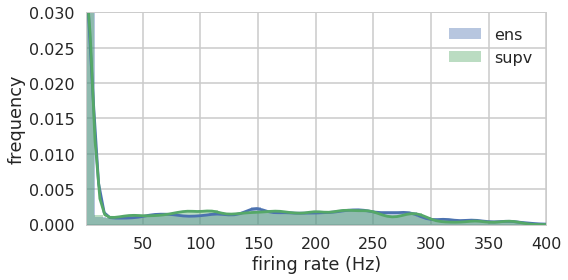

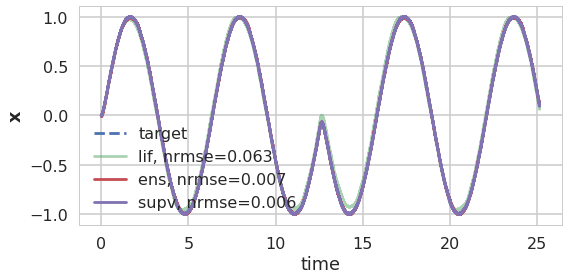

Simulating finished in 0:00:54.                                                 


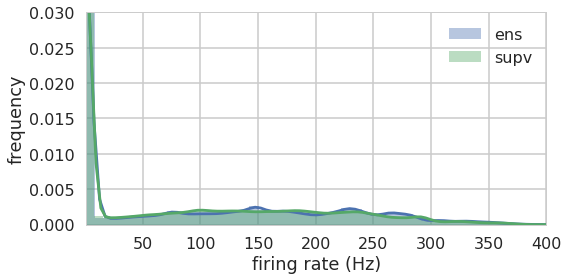

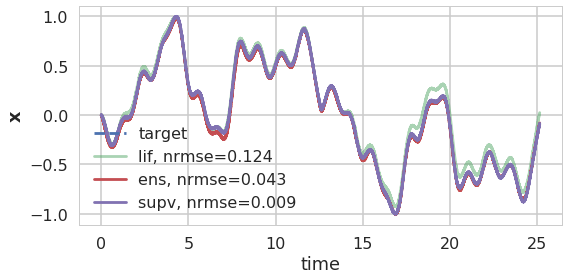

In [16]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

### white noise

Simulating finished in 0:00:57.                                                 
Simulating finished in 0:00:51.                                                 
Simulating finished in 0:01:08.                                                 


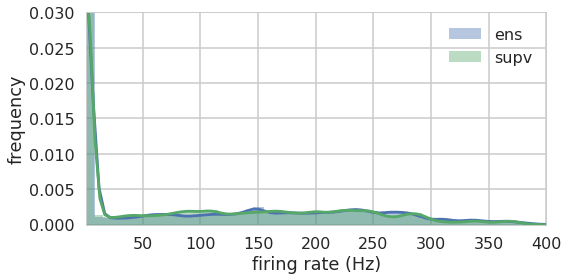

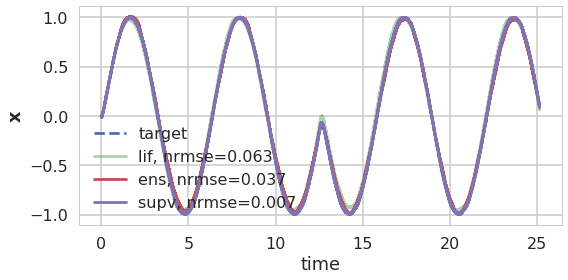

Simulating finished in 0:00:54.                                                 


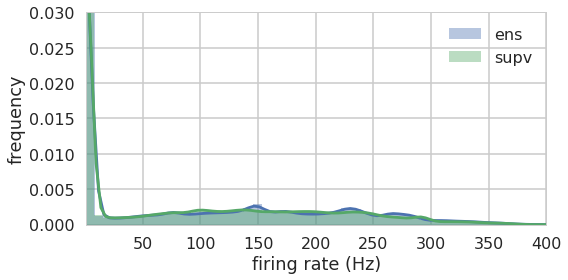

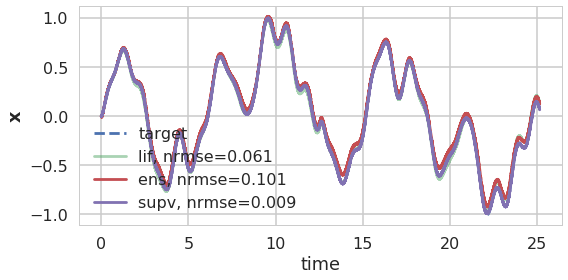

In [13]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(signal='white_noise', **kwargs)

### Train for 32$\pi$ sec (4x longer)

Simulating finished in 0:03:27.                                                 
Simulating finished in 0:03:34.                                                 
Simulating finished in 0:03:20.                                                 


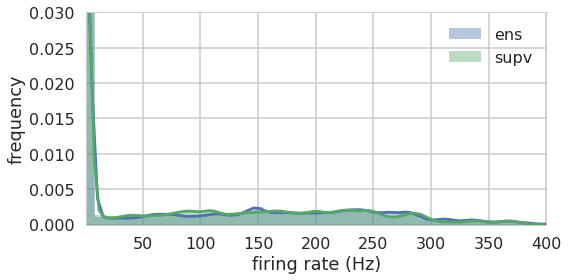

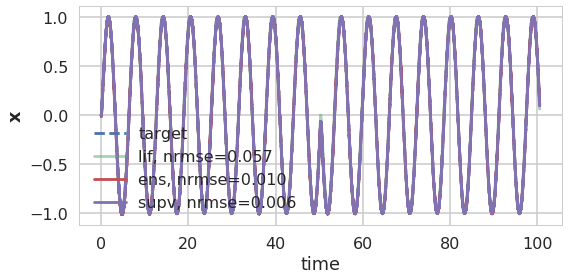

Simulating finished in 0:03:33.                                                 


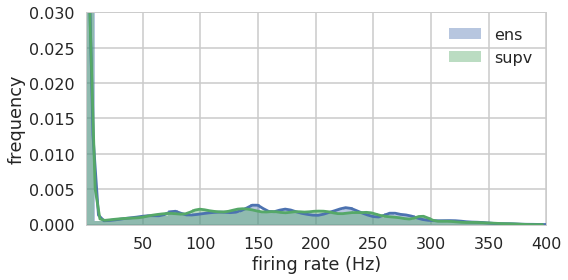

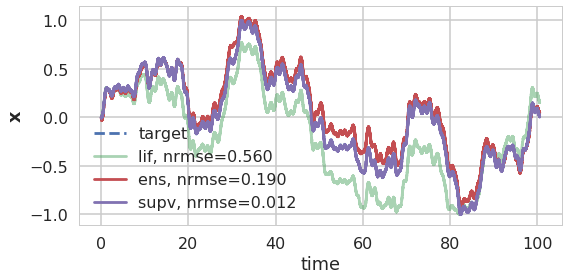

In [14]:
kwargs = dict(
    t=32*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=1e-4, **kwargs)

### Vary dt and dt_sample

Simulating finished in 0:08:43.                                                 
Simulating finished in 0:10:02.                                                 
Simulating finished in 0:08:18.                                                 


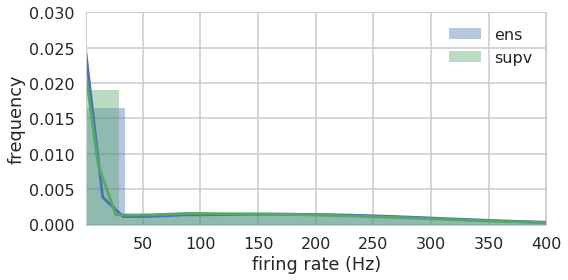

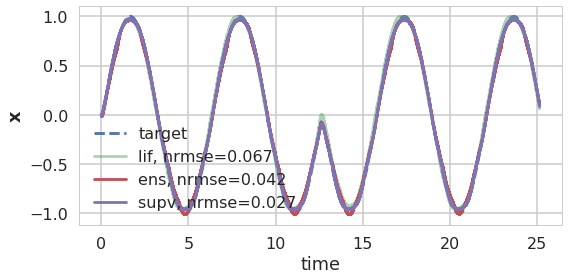

Simulating finished in 0:08:26.                                                 


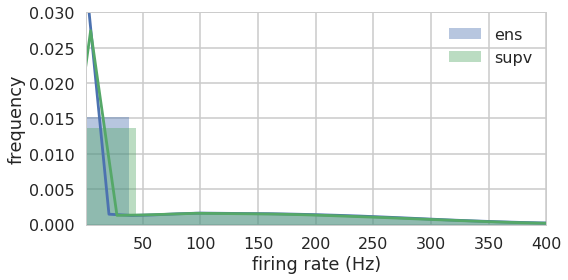

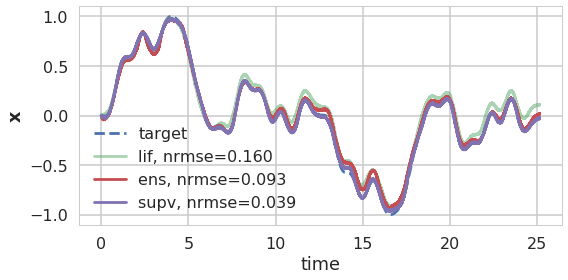

In [17]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

### 1000 neurons (up 10x from defult)

Simulating finished in 0:13:34.                                                 
Simulating finished in 0:15:00.                                                 
Simulating finished in 0:10:50.                                                 


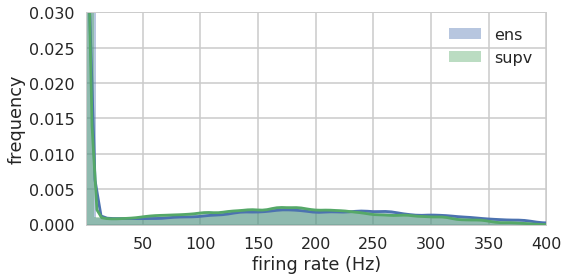

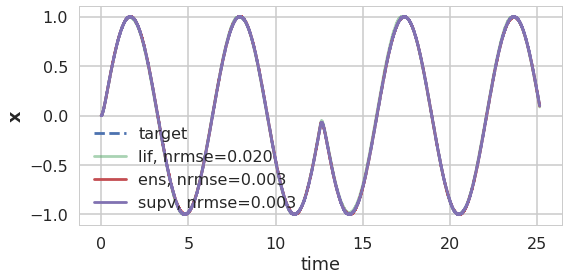

Simulating finished in 0:09:40.                                                 


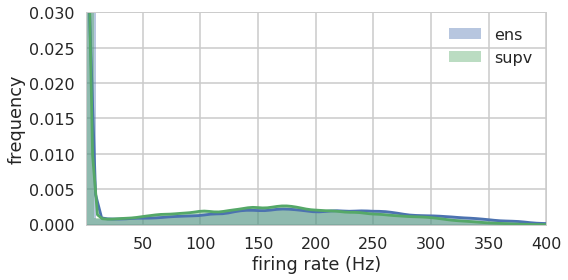

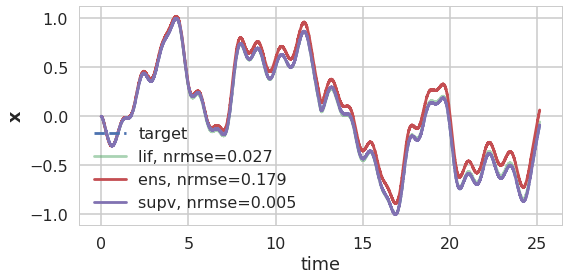

In [18]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

# ALIF

Simulating finished in 0:00:54.                                                 
Simulating finished in 0:00:52.                                                 
Simulating finished in 0:00:54.                                                 


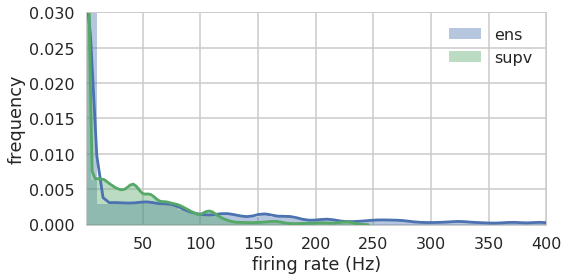

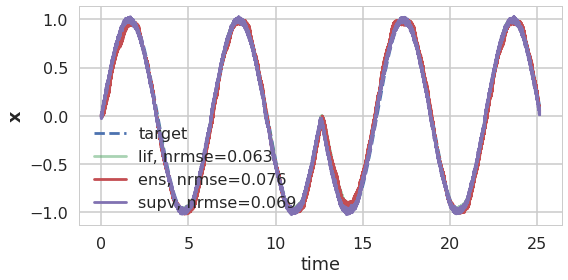

Simulating finished in 0:00:50.                                                 


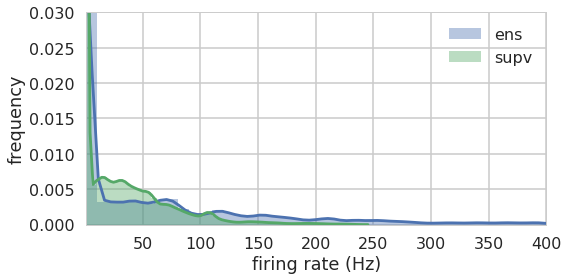

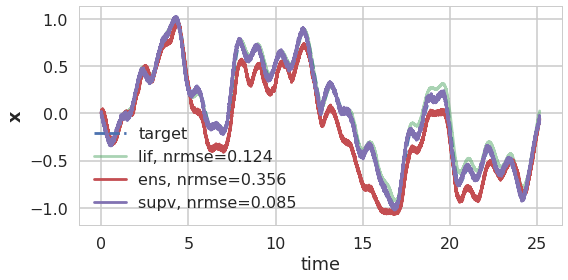

In [22]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=2e-3, **kwargs)

### 1000 neurons

Simulating finished in 0:09:43.                                                 
Simulating finished in 0:09:21.                                                 
Simulating finished in 0:10:20.                                                 


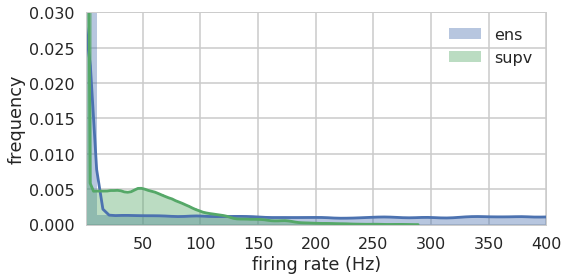

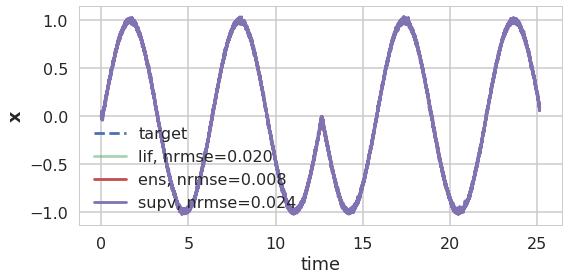

Simulating finished in 0:09:32.                                                 


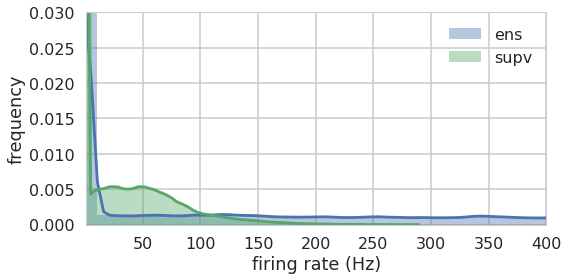

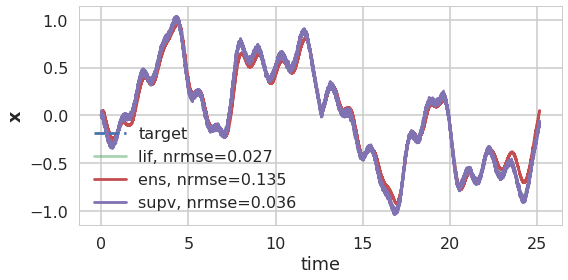

In [23]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=2e-3, **kwargs)

# Wilson Neuron

Simulating finished in 0:06:38.                                                 
Simulating finished in 0:08:24.                                                 
Simulating finished in 0:07:19.                                                 


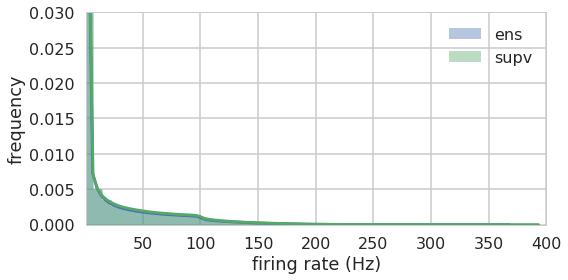

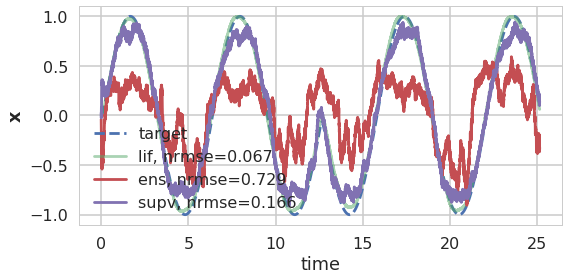

Simulating finished in 0:06:56.                                                 


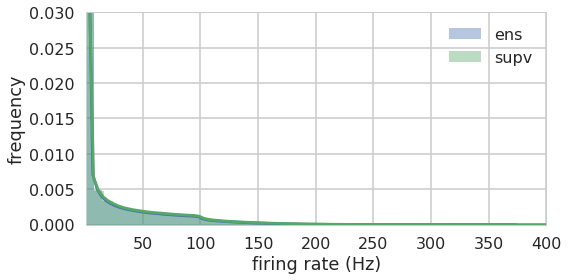

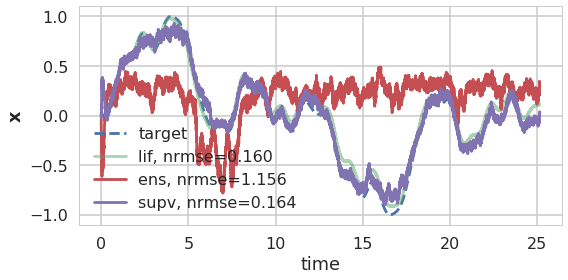

In [24]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=3e-3, **kwargs)

Simulating finished in 0:05:35.                                                 
Simulating finished in 0:06:19.                                                 
Simulating finished in 0:06:58.                                                 


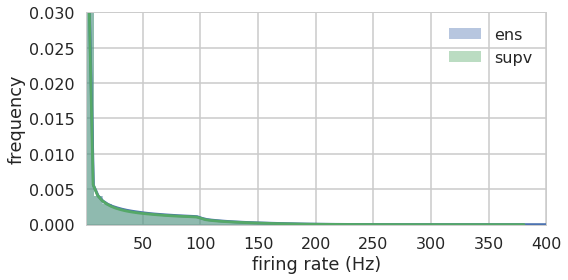

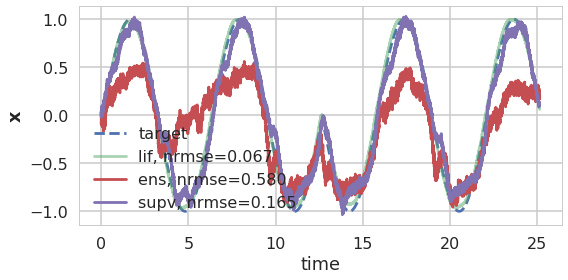

Simulating finished in 0:06:24.                                                 


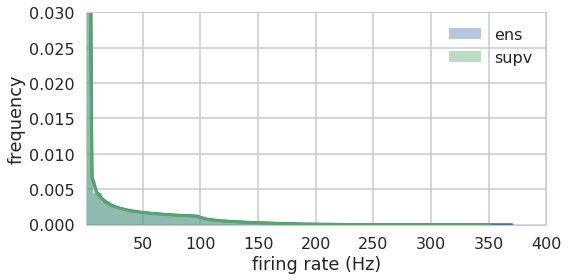

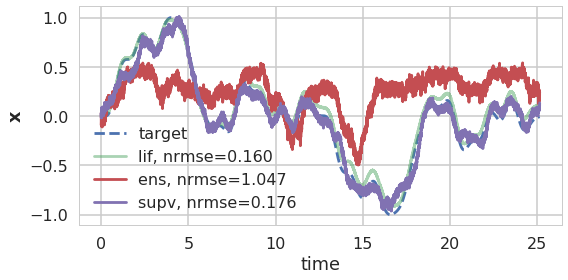

In [28]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=1e-3, **kwargs)

Simulating finished in 0:07:24.                                                 
Simulating finished in 0:07:30.                                                 
Simulating finished in 0:06:28.                                                 


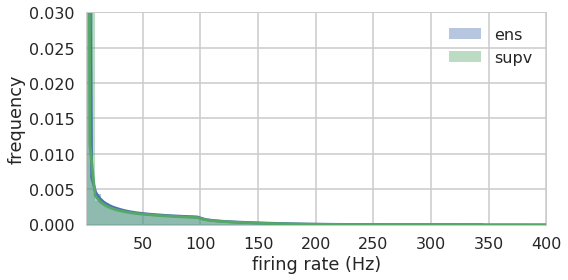

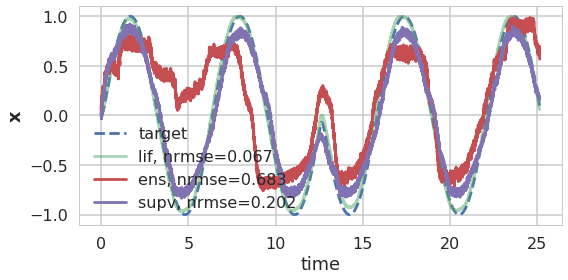

Simulating finished in 0:06:40.                                                 


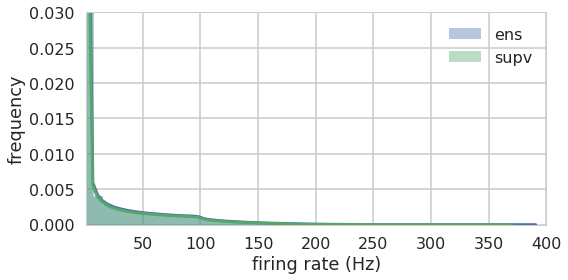

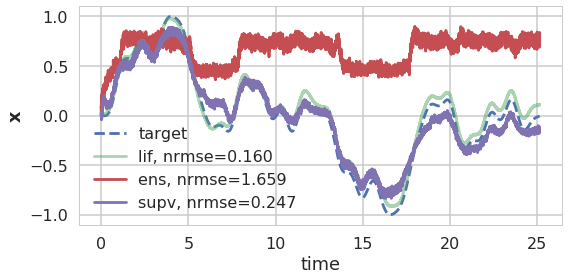

In [27]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=3e-4, **kwargs)

Simulating finished in 0:11:58.                                                 
Simulating finished in 0:12:36.                                                 
Simulating finished in 0:11:45.                                                 


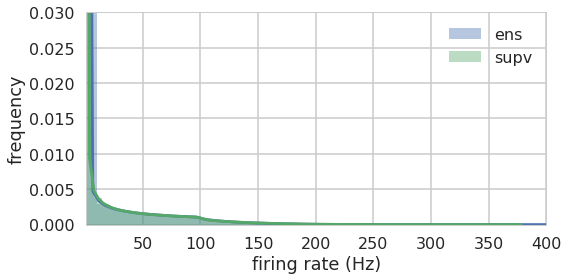

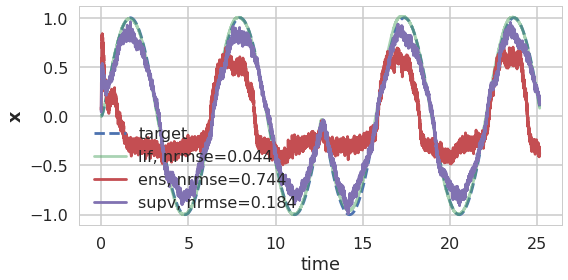

Simulating finished in 0:10:12.                                                 


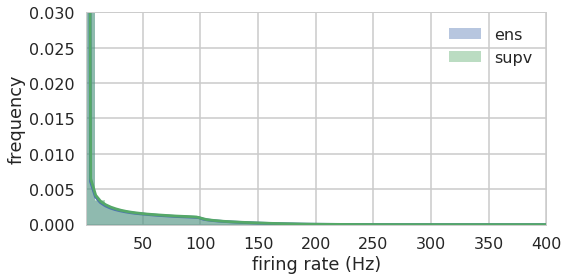

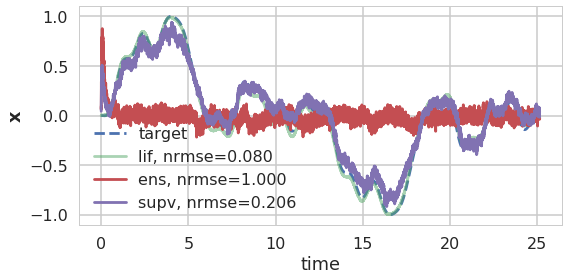

In [29]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-1, 1),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=1e-3, **kwargs)

### white noise

Simulating finished in 0:06:51.                                                 
Simulating finished in 0:06:48.                                                 
Simulating finished in 0:08:12.                                                 


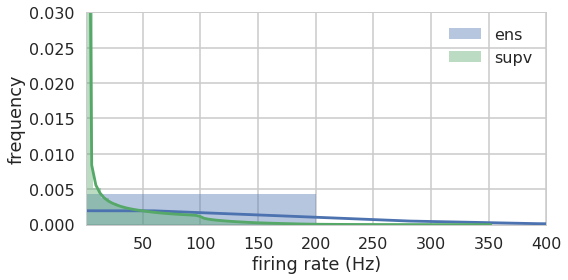

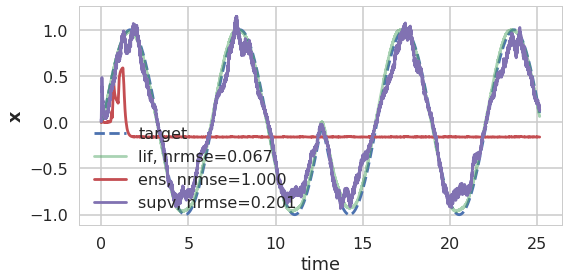

Simulating finished in 0:06:58.                                                 


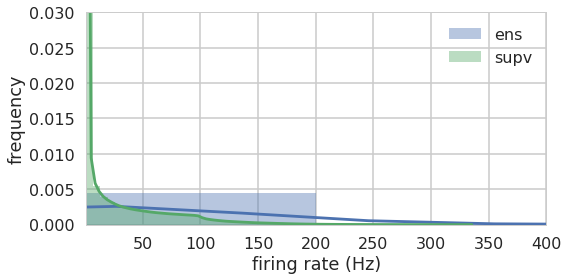

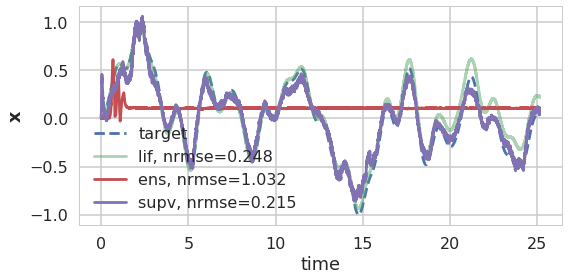

In [30]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=3e-3, signal='white_noise', **kwargs)

Simulating finished in 0:05:34.                                                 
Simulating finished in 0:06:11.                                                 
Simulating finished in 0:07:45.                                                 


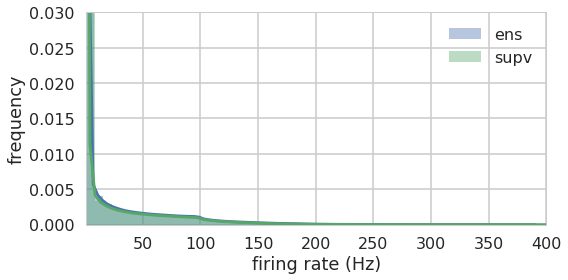

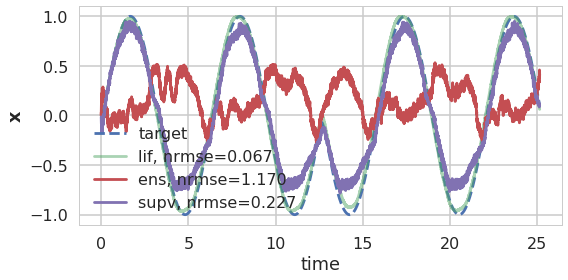

Simulating finished in 0:05:39.                                                 


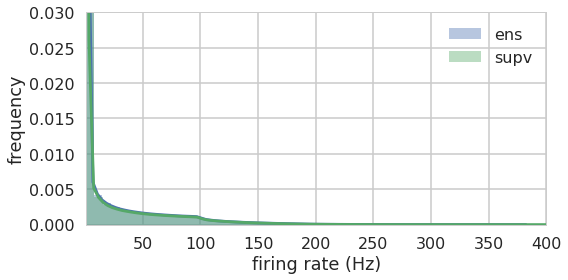

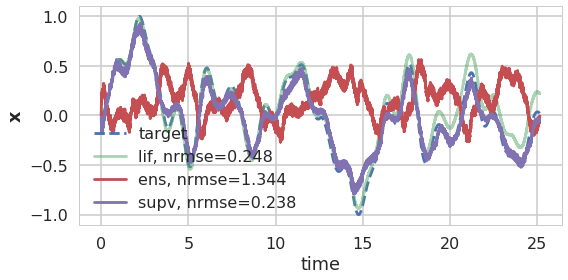

In [31]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=3e-4, signal='white_noise', **kwargs)

Simulating finished in 0:06:46.                                                 
Simulating finished in 0:05:45.                                                 
Simulating finished in 0:09:14.                                                 


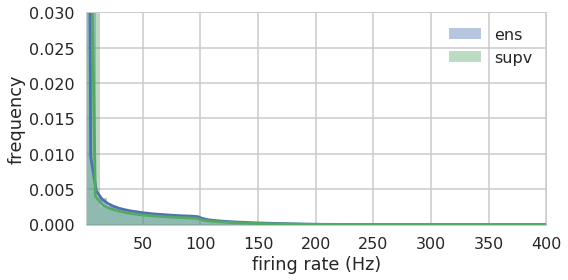

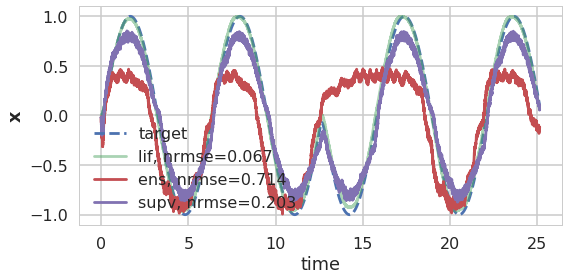

Simulating finished in 0:05:43.                                                 


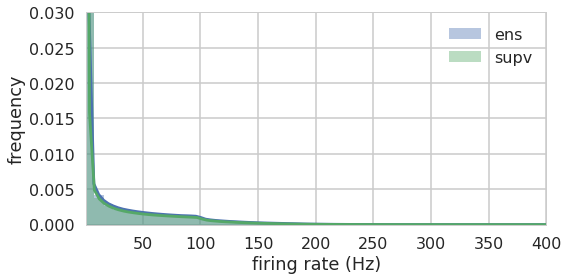

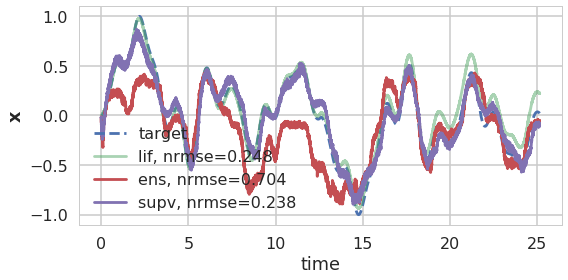

In [32]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=3e-5, signal='white_noise', **kwargs)

Simulating finished in 0:07:46.                                                 
Simulating finished in 0:06:48.                                                 
Simulating finished in 0:08:58.                                                 


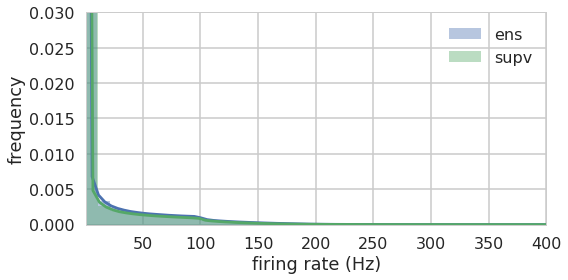

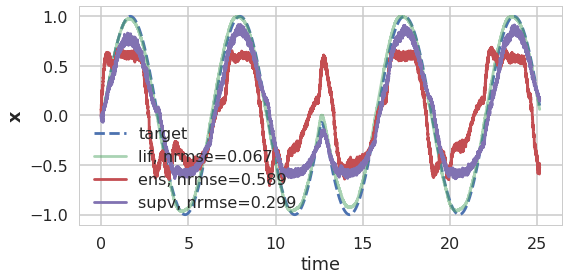

Simulating finished in 0:07:29.                                                 


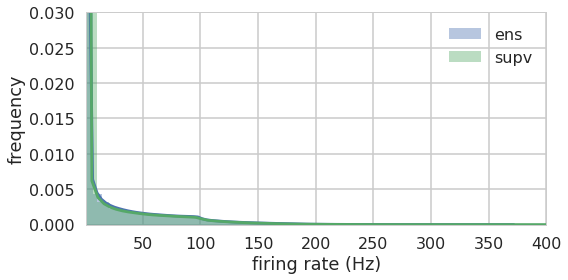

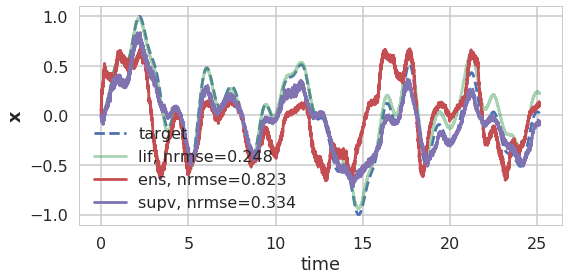

In [33]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=1e-4, signal='white_noise', **kwargs)

### 300 neurons

Simulating finished in 0:13:21.                                                 
Simulating finished in 0:12:08.                                                 
Simulating finished in 0:13:06.                                                 


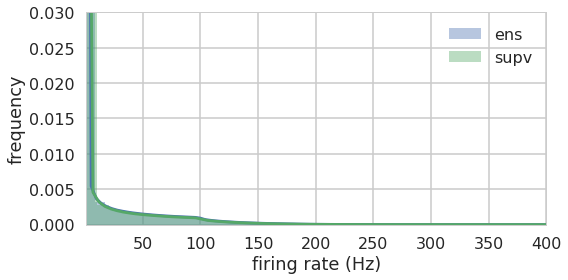

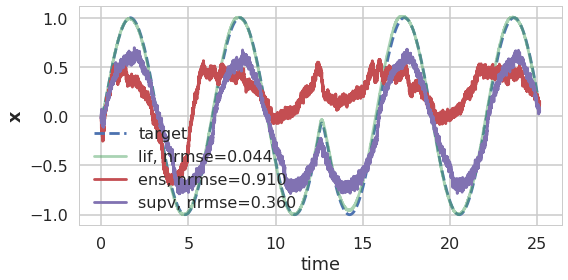

Simulating finished in 0:13:50.                                                 


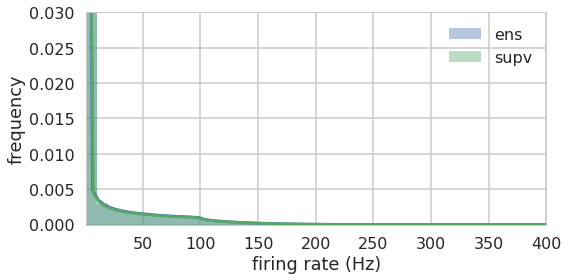

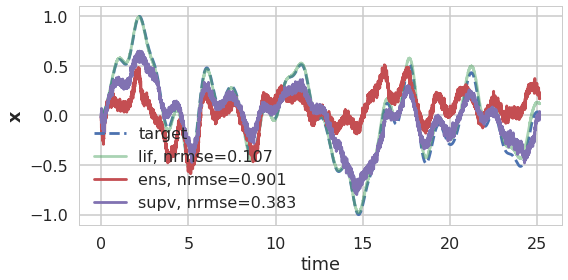

In [34]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-1, 1),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(sigma=1e-4, signal='white_noise', **kwargs)

Simulating finished in 0:08:00.                                                 
Simulating finished in 0:09:09.                                                 
Simulating finished in 0:07:52.                                                 


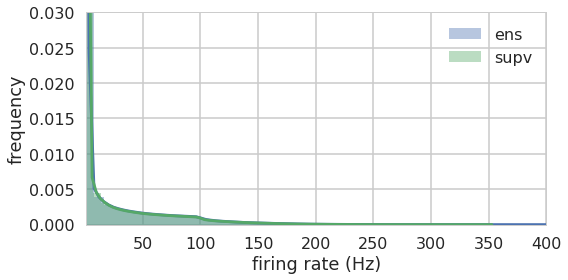

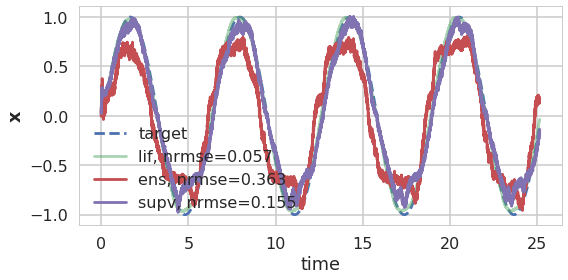

Simulating finished in 0:06:44.                                                 


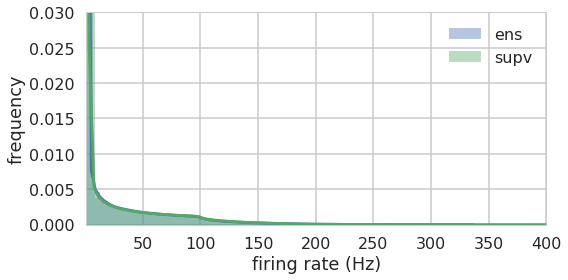

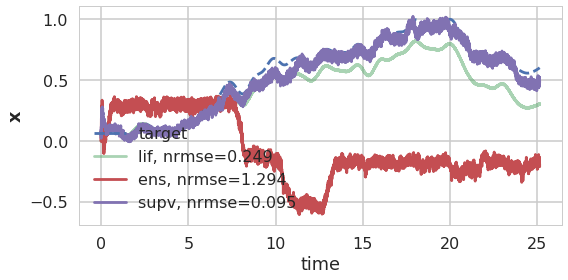

In [8]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

Simulating finished in 0:08:40.                                                 
Simulating finished in 0:07:45.                                                 
Simulating finished in 0:08:55.                                                 


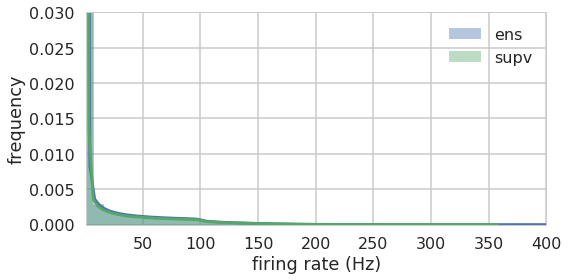

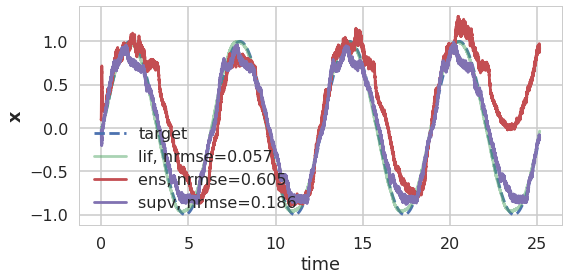

Simulating finished in 0:09:20.                                                 


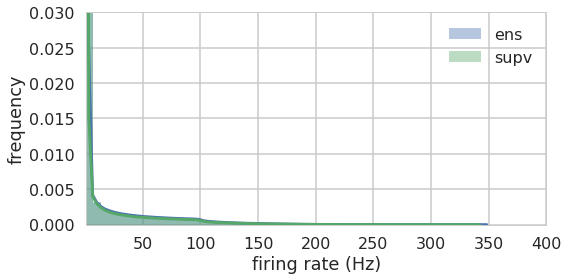

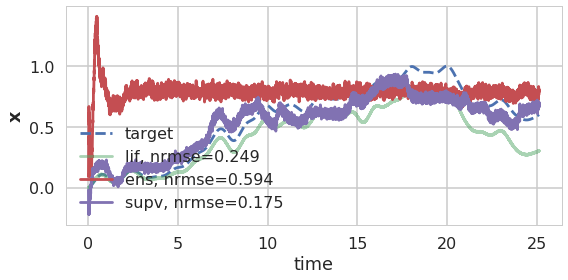

In [7]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-5, 5),
    bias=Uniform(-5, 5),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

### 300 neurons

Simulating finished in 0:14:56.                                                 
Simulating finished in 0:16:41.                                                 
Simulating finished in 0:15:28.                                                 


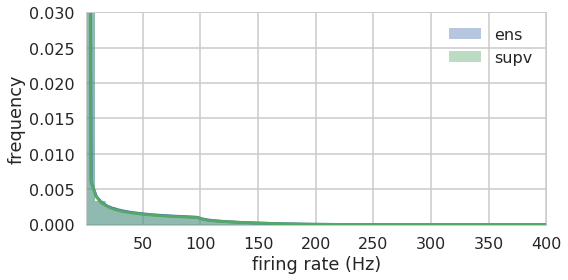

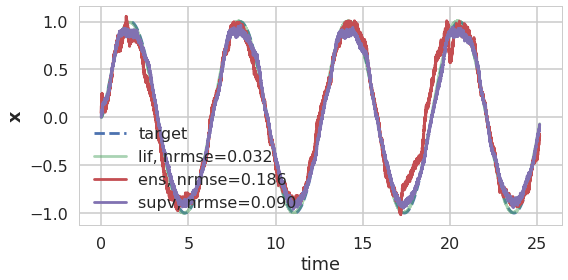

Simulating finished in 0:13:47.                                                 


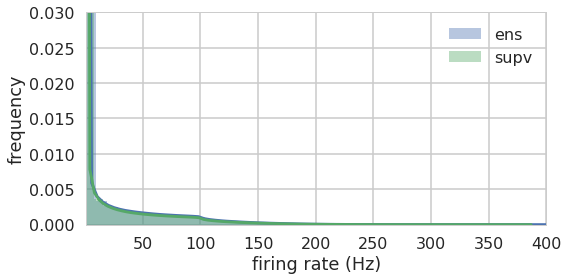

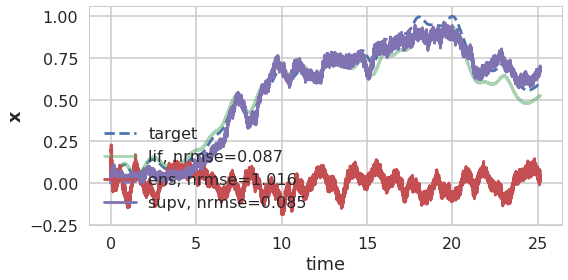

In [9]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

### 1000 neurons

Simulating finished in 2:12:18.                                                 
Simulating finished in 2:17:32.                                                 
Simulating finished in 1:43:25.                                                 


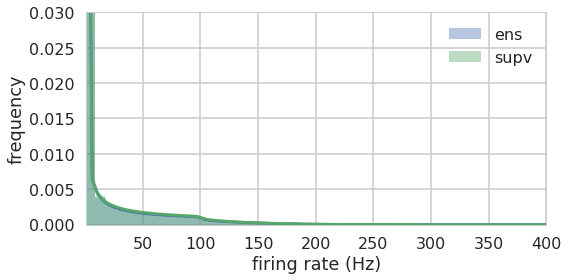

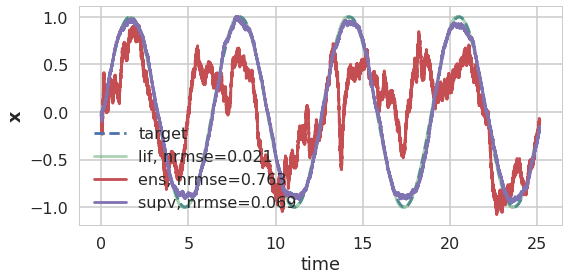

Simulating finished in 1:41:24.                                                 


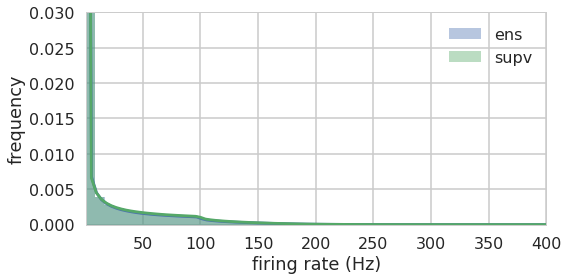

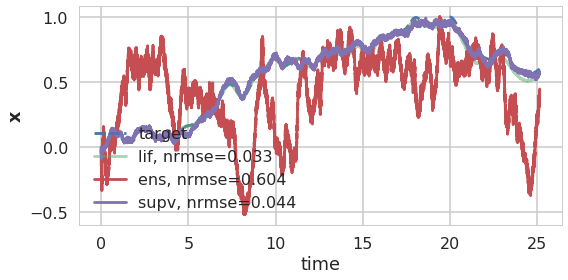

In [7]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)

Simulating finished in 0:35:42.                                                 
Simulating finished in 0:36:07.                                                 
Simulating finished in 0:35:29.                                                 


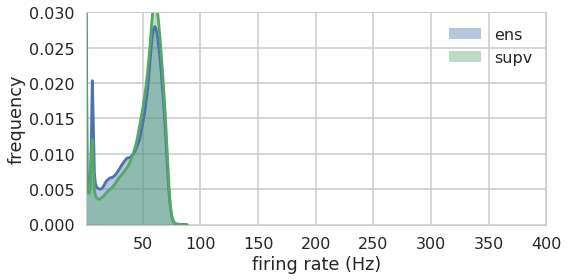

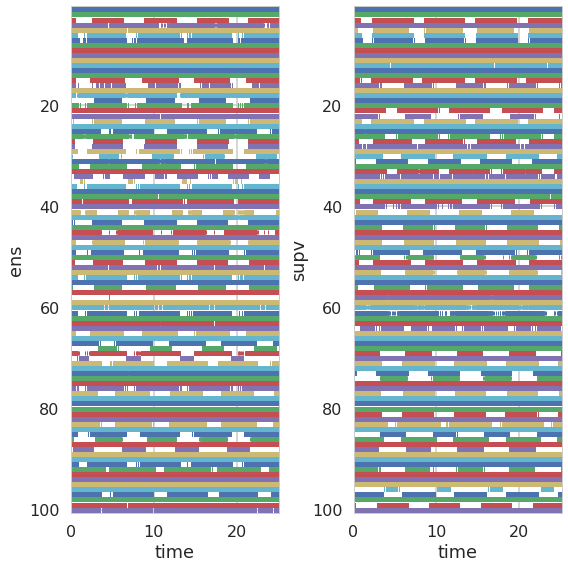

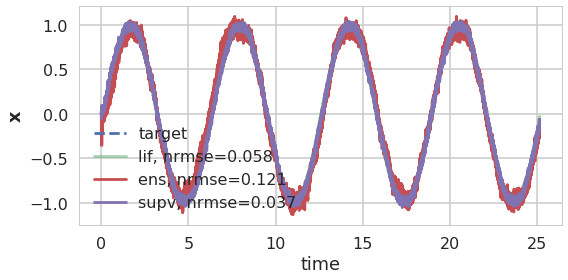

Simulating finished in 0:42:53.                                                 


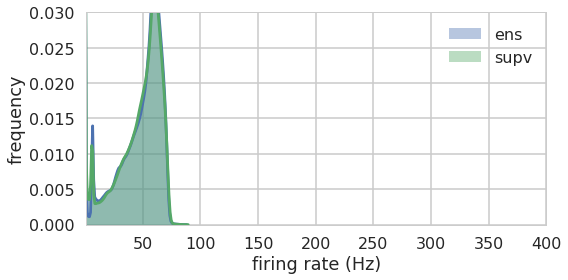

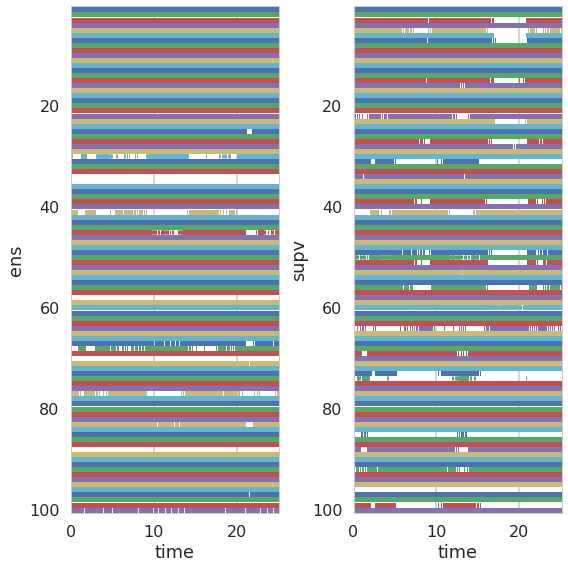

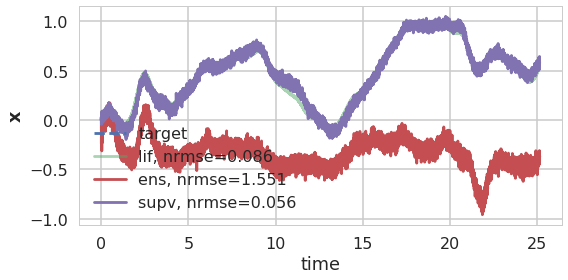

In [21]:
kwargs = dict(
    t=8*np.pi,
    dt=0.000025,
    dt_sample=0.000025,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

P_ens, J_ens, d_ens, d_supv = full_force(**kwargs)